# Brazil Real Estate Pricing Research

In [ ]:
#| hide
import pandas as pd
import numpy as np
import datetime
import typing as t
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pickle

In [ ]:
#| hide
np.random.seed(42)

I want to predict future prices for houses. To do it, my plan is to build a model to predict price given a set of features (like number of rooms, square footage, etc) and a date in the range of my data (2013 to 2016) and another model to build this forecast to current prices (2023). Heres my [initial dataset](https://www.kaggle.com/datasets/devvret/brazil-real-estate-listings/).

In [ ]:
raw_df = pd.read_csv("properati-BR-2016-11-01-properties-sell.csv", sep=",")

## Data cleaning

The dataset has a lot of columns but I'm going to use only a subset of them.

- created_on
- property_type
- lat
- lon
- price
- surface_covered_in_m2
- rooms
- description

In [ ]:
df = raw_df[
    raw_df.created_on.notnull()
    & raw_df.lat.notnull()
    & raw_df.lon.notnull()
    & raw_df.price.notnull()
    & raw_df.rooms.notnull()
    & raw_df.surface_covered_in_m2.notnull()
    & (raw_df.surface_covered_in_m2 > 0)
    & (raw_df.surface_covered_in_m2 < 5000)
    & (raw_df.currency == "BRL")
][
    [
        "lat",
        "lon",
        "created_on",
        "property_type",
        "price",
        "surface_covered_in_m2",
        "rooms",
        "description"
    ]
]
df.created_on = pd.to_datetime(df.created_on)
df.head(3)

,lat,lon,created_on,property_type,price,surface_covered_in_m2,rooms,description
792,-3.474983,-38.928616,2013-06-26,house,5000000.0,1000.0,8.0,"Casa de praia em Taíba, a apenas 67 km de Fort..."
794,-23.547697,-46.657379,2013-09-04,apartment,2000000.0,180.0,3.0,EXCELENTE OPORTUNIDADE!!\n\nAPARTAMENTO TOTALM...
795,-23.545349,-46.659519,2013-09-04,apartment,960000.0,109.0,3.0,"IMOVEL SITO NA RUA ALAGOAS, BEM LOCALIZADO, EM..."


I would love to use "floor" and "surface_total_in_m2" as features but they are filled for less then 10% for the dataset. The "description" column wasn't dropped to enable single row analysis to identify anomalies or outliers. In the future it can be used with NLP to improve price prediction accuracy.

In [ ]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 872672 entries, 0 to 872671
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   created_on                  872672 non-null  object 
 1   operation                   872672 non-null  object 
 2   property_type               872672 non-null  object 
 3   place_name                  872672 non-null  object 
 4   place_with_parent_names     872672 non-null  object 
 5   geonames_id                 140 non-null     float64
 6   lat-lon                     387227 non-null  object 
 7   lat                         387227 non-null  float64
 8   lon                         387227 non-null  float64
 9   price                       819401 non-null  float64
 10  currency                    819382 non-null  object 
 11  price_aprox_local_currency  819401 non-null  float64
 12  price_aprox_usd             819401 non-null  float64
 13  surface_total_

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 161731 entries, 792 to 872667
Data columns (total 8 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   lat                    161731 non-null  float64       
 1   lon                    161731 non-null  float64       
 2   created_on             161731 non-null  datetime64[ns]
 3   property_type          161731 non-null  object        
 4   price                  161731 non-null  float64       
 5   surface_covered_in_m2  161731 non-null  float64       
 6   rooms                  161731 non-null  float64       
 7   description            161731 non-null  object        
dtypes: datetime64[ns](1), float64(5), object(2)
memory usage: 11.1+ MB


Here's a geographical view of the data. For viewing purposes we are limiting the price and for future comparison we are going to "zoom in" Belo Horizonte (BH), which is a big city, filter to only apartments with 1 room and square footage between 60 and 80.

In [ ]:
bh_lats = (-19.99491, -19.83163)
bh_longs = (-44.02857, -43.90612)
price_limit = 900000

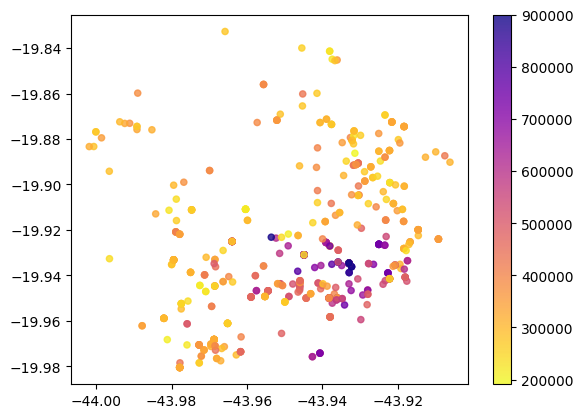

In [ ]:
bh_df = df[
    (df.lat > bh_lats[0])
    & (df.lat < bh_lats[1])
    & (df.lon > bh_longs[0])
    & (df.lon < bh_longs[1])
    & (df.property_type == "apartment")
    & (df.surface_covered_in_m2 > 60)
    & (df.surface_covered_in_m2 < 80)
    & (df.rooms == 1)
]
bh_df.loc[bh_df.price > price_limit, "price"] = price_limit
plt.scatter(
    bh_df["lon"],
    bh_df["lat"],
    s=20,
    c=bh_df["price"],
    cmap="plasma_r",
    alpha=0.8
)
plt.colorbar()
plt.show()

## Data preprocessing

To prepare our data to machine learning model, we need to parse categorial features into numbers. To do it, we are using one hot encoding.

In [ ]:
def prepare_one_hots(x: pd.DataFrame) -> pd.DataFrame:
    x.loc[:, "is_house"] = 0
    x.loc[x.property_type == "house", "is_house"] = 1

    x.loc[:, "is_apartment"] = 0
    x.loc[x.property_type == "apartment", "is_apartment"] = 1

    x.loc[:, "is_PH"] = 0
    x.loc[x.property_type == "PH", "is_PH"] = 1

    x.loc[:, "is_store"] = 0
    x.loc[x.property_type == "store", "is_store"] = 1

    x.drop(columns=["property_type"], inplace=True)
    return x

def prepare(x: pd.DataFrame) -> pd.DataFrame:
    new_x = x.copy()
    new_x.created_on = new_x.created_on.map(datetime.datetime.toordinal)
    new_x.drop(columns=["description"], inplace=True)
    return prepare_one_hots(new_x)

prepared_df = prepare(df)
prepared_df.head(3)

,lat,lon,created_on,price,surface_covered_in_m2,rooms,is_house,is_apartment,is_PH,is_store
792,-3.474983,-38.928616,735045,5000000.0,1000.0,8.0,1,0,0,0
794,-23.547697,-46.657379,735115,2000000.0,180.0,3.0,0,1,0,0
795,-23.545349,-46.659519,735115,960000.0,109.0,3.0,0,1,0,0


Before start training, we are going to split our dataset into training dataset and validation dataset.

In [ ]:
def split_dataset(
    dataset: pd.DataFrame, test_ratio: float = 0.30
) -> t.Tuple[pd.DataFrame, pd.DataFrame]:
    test_indices = np.random.rand(len(dataset)) < test_ratio
    return dataset[~test_indices], dataset[test_indices]

train, valid = split_dataset(prepared_df)
X_train = train.loc[:, train.columns != "price"].to_numpy()
y_train = train.price.to_numpy()
X_valid = valid.loc[:, valid.columns != "price"].to_numpy()
y_valid = valid.price.to_numpy()
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(113286, 9)
(113286,)
(48445, 9)
(48445,)


## Sanity checks

Even with the validation dataset we want to make some sanity checks after the training. To do it so, we built this function which evaluates the model with specific features. It's a *curried* function because there are some standarized checks to apply to all models.

In [ ]:
def eval(
    lat: t.Union[float, np.ndarray],
    lon: t.Union[float, np.ndarray],
    created_on: t.Union[datetime.date, t.List[datetime.date]],
    property_type: t.Literal["apartment", "house"],
    surface_covered_in_m2: t.Union[float, np.ndarray],
    rooms: t.Union[int, np.ndarray]
) -> t.Callable[[t.Any], pd.DataFrame]:

    lat_vec = lat if isinstance(lat, np.ndarray) else np.array([lat])
    lon_vec = lon if isinstance(lon, np.ndarray) else np.array([lon])
    created_on_vec = (
        np.array([c.toordinal() for c in created_on])
        if isinstance(created_on, t.List)
        else np.array([created_on.toordinal()])
    )
    surface_covered_in_m2_vec = (
        surface_covered_in_m2
        if isinstance(surface_covered_in_m2, np.ndarray)
        else np.array([surface_covered_in_m2])
    )
    rooms_vec = rooms if isinstance(rooms, np.ndarray) else np.array([rooms])

    m = np.vstack(
        [v.ravel() for v in np.meshgrid(
            lat_vec,
            lon_vec,
            created_on_vec,
            surface_covered_in_m2_vec,
            rooms_vec,
            indexing="ij"
        )]
    ).T

    x_df = prepare_one_hots(pd.DataFrame(
        {
            "lat": m[:, 0],
            "lon": m[:, 1],
            "created_on": m[:, 2],
            "property_type": [property_type] * len(m),
            "surface_covered_in_m2": m[:, 3],
            "rooms": m[:, 4]
        }
    ))
    x = x_df.to_numpy()

    def fn(model: t.Any) -> pd.DataFrame:
        y = model.predict(x)
        x_df["price"] = y.reshape(len(m))
        x_df.price = x_df.price.round(2)
        return x_df
    return fn

Here's all sanity checks:

In [ ]:
lats, longs = np.linspace(bh_lats[0], bh_lats[1], 100), np.linspace(bh_longs[0], bh_longs[1], 50)

santacruz = (-19.87755, -43.94184)
sion = (-19.95408, -43.93163)

start = datetime.date(2013, 7, 1)
date_list = [start + datetime.timedelta(days=x) for x in range(365*3)]

bh_heatmap_check = eval(lats, longs, datetime.date(2016, 1, 1), "apartment", 70, 1)
santa_cruz_price_evolution = eval(santacruz[0], santacruz[1], date_list, "apartment", 70, np.array([1, 2, 3]))
sion_price_evolution = eval(sion[0], sion[1], date_list, "apartment", 70, np.array([1, 2, 3]))

Here's a function to plot everything once:

In [ ]:
def sanity_checks(model: t.Any, set_color_bounds: bool = False) -> None:
    bh_heatmap = bh_heatmap_check(model)
    santa_cruz = santa_cruz_price_evolution(model)
    sion = sion_price_evolution(model)

    bh_heatmap.loc[bh_heatmap.price > price_limit, "price"] = price_limit

    fig, ax = plt.subplots(3, figsize=(5, 15))

    ax[0].title.set_text("BH price heatmap")
    scatter = ax[0].scatter(
        bh_heatmap["lon"],
        bh_heatmap["lat"],
        s=20,
        c=bh_heatmap["price"],
        cmap="plasma_r",
        alpha=0.8,
        **({"norm": colors.Normalize(vmin=0,vmax=price_limit)} if set_color_bounds else {})
    )
    fig.colorbar(scatter)

    ax[1].title.set_text("Santa Cruz price evolution")
    ax[1].plot(date_list, santa_cruz[santa_cruz.rooms == 1].price.rolling(30).mean(), label="1 room")
    ax[1].plot(date_list, santa_cruz[santa_cruz.rooms == 2].price.rolling(30).mean(), label="2 rooms")
    ax[1].plot(date_list, santa_cruz[santa_cruz.rooms == 3].price.rolling(30).mean(), label="3 rooms")
    ax[1].legend()
    plt.setp(ax[1].get_xticklabels(), rotation=30, horizontalalignment='right')

    ax[2].title.set_text("Sion price evolution")
    ax[2].plot(date_list, sion[sion.rooms == 1].price.rolling(30).mean(), label="1 room")
    ax[2].plot(date_list, sion[sion.rooms == 2].price.rolling(30).mean(), label="2 rooms")
    ax[2].plot(date_list, sion[sion.rooms == 3].price.rolling(30).mean(), label="3 rooms")
    ax[2].legend()
    plt.setp(ax[2].get_xticklabels(), rotation=30, horizontalalignment='right')

    fig.show()

## Random Forest

We are going to give a try to the Random Forest model.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
#| notest
rf = RandomForestRegressor(max_depth=10, random_state=0)

rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, random_state=0)

In [ ]:
#| hide
#| notest
pickle.dump(rf, open("rf.pickle", "wb"))

In [ ]:
#| hide
rf = pickle.load(open("rf.pickle", "rb"))

In [ ]:
rf.score(X_valid, y_valid)

0.7125046159284849

/tmp/ipykernel_121093/2726626927.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


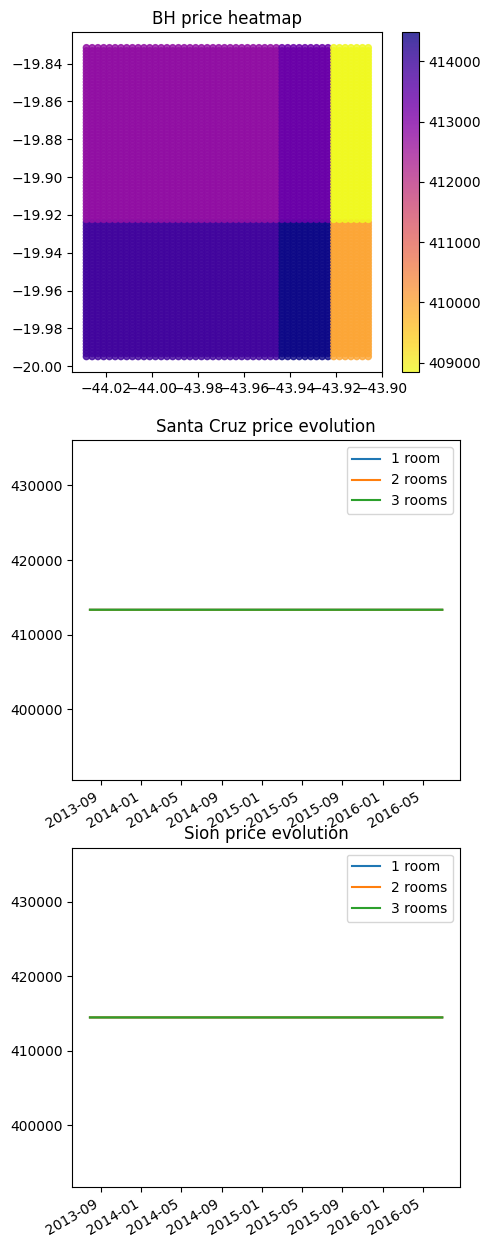

In [ ]:
sanity_checks(rf)

## KNN

We are going to give a try to KNN.

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
#| notest
knn = KNeighborsRegressor(n_neighbors=7, weights="distance")
knn.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=7, weights='distance')

In [ ]:
#| hide
#| notest
pickle.dump(knn, open("knn.pickle", "wb"))

In [ ]:
#| hide
knn = pickle.load(open("knn.pickle", "rb"))

In [ ]:
knn.score(X_valid, y_valid)

0.4476726937780481

/tmp/ipykernel_121093/2726626927.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


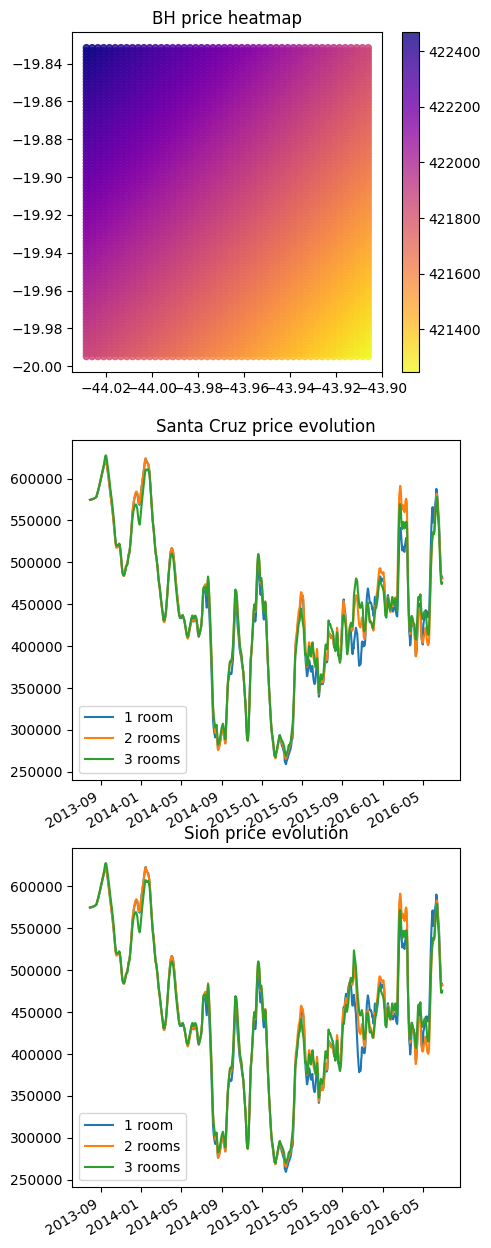

In [ ]:
sanity_checks(knn)

## Neural Networks

We are going to give a try to neural networks.

In [ ]:
from sklearn.neural_network import MLPRegressor

In [ ]:
#| notest
nn = MLPRegressor(
    hidden_layer_sizes=(64, 32, 16, 8),
    verbose=True,
    max_iter=200,
    batch_size=32,
    early_stopping=True,
    random_state=0
)

nn.fit(X_train, y_train)

Iteration 1, loss = 989008557475.24633789
Validation score: 0.000894
Iteration 2, loss = 982935525969.45141602
Validation score: 0.002829
Iteration 3, loss = 979176376597.19042969
Validation score: 0.010544
Iteration 4, loss = 921476085351.42651367
Validation score: 0.250087
Iteration 5, loss = 678939338304.96813965
Validation score: 0.250278
Iteration 6, loss = 669330297793.80725098
Validation score: 0.232528
Iteration 7, loss = 662734344459.26306152
Validation score: 0.160682
Iteration 8, loss = 672457279714.23901367
Validation score: 0.215570
Iteration 9, loss = 666777088124.32995605
Validation score: 0.253333
Iteration 10, loss = 665667439353.60107422
Validation score: 0.176052
Iteration 11, loss = 662182312620.68090820
Validation score: 0.263457
Iteration 12, loss = 660568472090.76025391
Validation score: 0.176352
Iteration 13, loss = 665260580551.61169434
Validation score: 0.267875
Iteration 14, loss = 660553267314.93041992
Validation score: 0.221419
Iteration 15, loss = 66319634

MLPRegressor(batch_size=32, early_stopping=True,
             hidden_layer_sizes=(64, 32, 16, 8), random_state=0, verbose=True)

In [ ]:
#| hide
#| notest
pickle.dump(nn, open("nn.pickle", "wb"))

In [ ]:
#| hide
nn = pickle.load(open("nn.pickle", "rb"))

In [ ]:
nn.score(X_valid, y_valid)

0.44646501729966925

<Axes: >

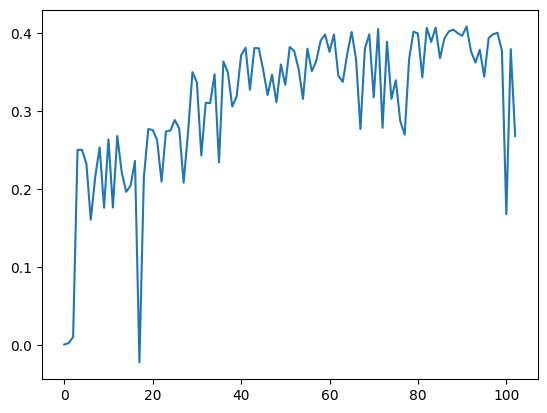

In [ ]:
pd.Series(nn.validation_scores_).plot()

/tmp/ipykernel_121093/2726626927.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


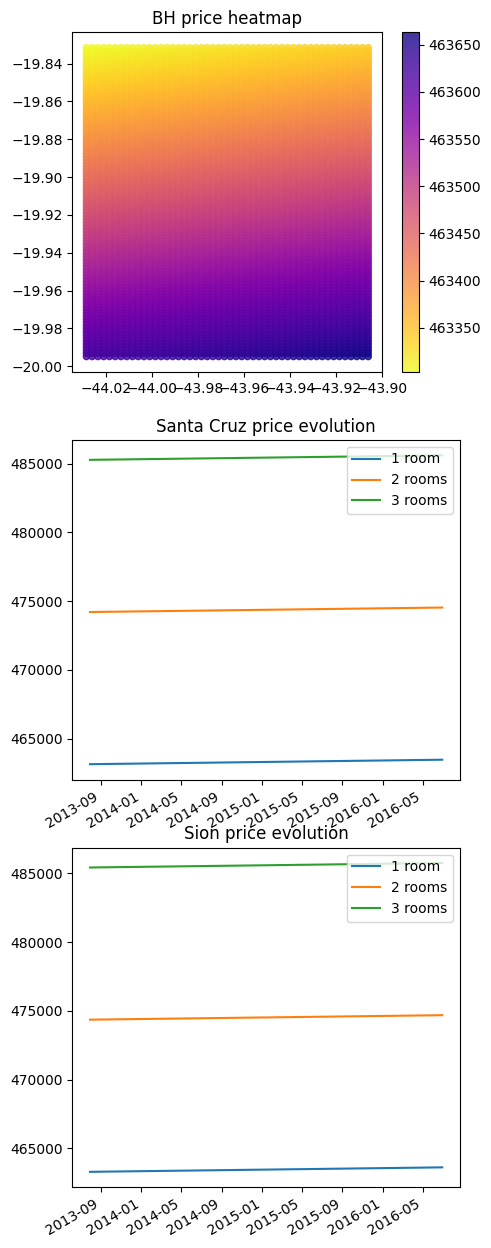

In [ ]:
sanity_checks(nn)

## Spatial Boosted Random Forest

In [ ]:
from knn_spatial_boost.core import KNNSpatialBooster

In [ ]:
#| notest
boosted_rf = KNNSpatialBooster(
    n_neighbors=1,
    temperature=0.5,
    n_loops=1,
    spatial_features=[0, 1],
    remove_target_spatial_cols=True,
    remove_neighbor_spatial_cols=True,
    estimator=RandomForestRegressor(max_depth=10, random_state=0),
)

boosted_rf.fit(X_train, y_train)

Running loop #0


In [ ]:
#| hide
#| notest
pickle.dump(boosted_rf, open("boosted_rf.pickle", "wb"))

In [ ]:
#| hide
boosted_rf = pickle.load(open("boosted_rf.pickle", "rb"))

In [ ]:
boosted_rf.score(X_valid, y_valid)

0.6905779116864287

/tmp/ipykernel_128503/2726626927.py:36: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


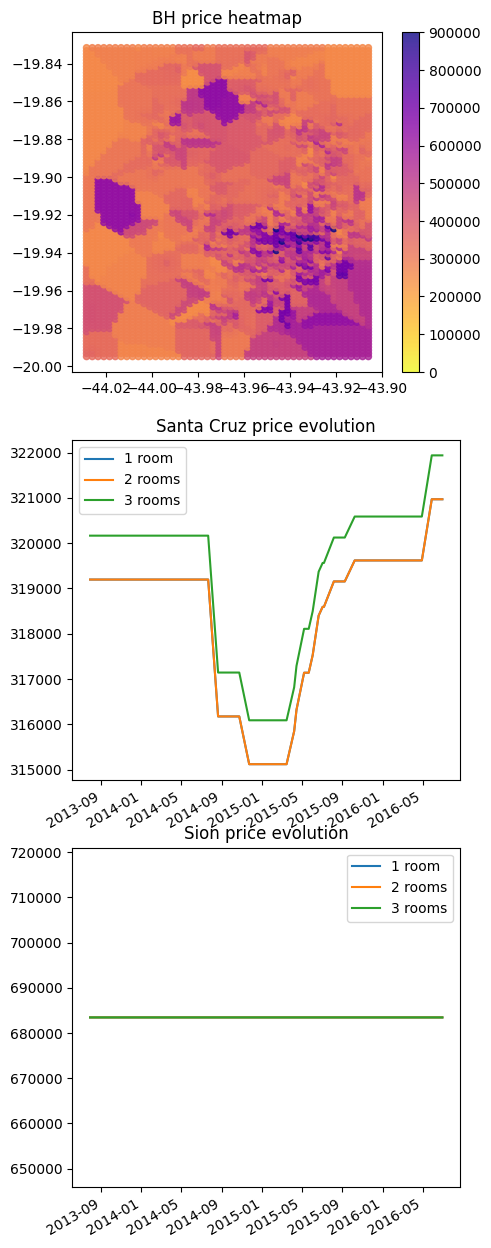

In [ ]:
sanity_checks(boosted_rf, set_color_bounds=True)

## Spatial Boosted Neural Network

After getting vertical and horizontal patterns using Random Forest and concluding we need a lot more training time to fit a neural network to the data, 

In [ ]:
#| notest
boosted_nn = KNNSpatialBooster(
    n_neighbors=1,
    temperature=0.5,
    n_loops=10,
    spatial_features=[0, 1],
    remove_target_spatial_cols=True,
    remove_neighbor_spatial_cols=True,
    estimator=MLPRegressor(
        hidden_layer_sizes=(32, 16, 8),
        warm_start=True,
        early_stopping=True,
        tol=1e-10,
        n_iter_no_change=20,
        verbose=True,
        max_iter=10,
        batch_size=32,
        random_state=0
    ),
)

boosted_nn.fit(X_train, y_train)

Running loop #0
Iteration 1, loss = 689341798460.03491211
Validation score: 0.372473
Iteration 2, loss = 662257906664.58239746
Validation score: 0.370708
Iteration 3, loss = 665191893872.98034668
Validation score: 0.377532
Iteration 4, loss = 654936643923.76062012
Validation score: 0.379296
Iteration 5, loss = 654954084773.73571777
Validation score: 0.381208
Iteration 6, loss = 651217437466.08984375
Validation score: 0.383253
Iteration 7, loss = 648323560149.41662598
Validation score: 0.377769
Iteration 8, loss = 650232907496.79089355
Validation score: 0.381716
Iteration 9, loss = 647383979147.78479004
Validation score: 0.379614
Iteration 10, loss = 643254685417.98974609
Validation score: 0.377064
Running loop #1


/home/pedro/repos/knn-spatial-boost/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 644576429521.15612793
Validation score: 0.423854
Iteration 2, loss = 645496008286.36608887
Validation score: 0.419885
Iteration 3, loss = 642364076782.40258789
Validation score: 0.440455
Iteration 4, loss = 639622766361.89904785
Validation score: 0.425594
Iteration 5, loss = 641817775703.78833008
Validation score: 0.438917
Iteration 6, loss = 639902828060.48889160
Validation score: 0.432710
Iteration 7, loss = 640335005772.96398926
Validation score: 0.441504
Iteration 8, loss = 637184839366.75305176
Validation score: 0.425407
Iteration 9, loss = 640519432447.82421875
Validation score: 0.419851
Iteration 10, loss = 634250198777.53637695
Validation score: 0.420139
Running loop #2


/home/pedro/repos/knn-spatial-boost/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 645671526754.46545410
Validation score: 0.429361
Iteration 2, loss = 644294849788.64880371
Validation score: 0.423562
Iteration 3, loss = 644195866245.46154785
Validation score: 0.440786
Iteration 4, loss = 641764651092.91186523
Validation score: 0.423488
Iteration 5, loss = 641139494187.41503906
Validation score: 0.436657
Iteration 6, loss = 643336856645.35803223
Validation score: 0.441065
Iteration 7, loss = 642114011303.76513672
Validation score: 0.435979
Iteration 8, loss = 638761743555.58447266
Validation score: 0.438838
Iteration 9, loss = 641163422370.85290527
Validation score: 0.426221
Iteration 10, loss = 631240720635.49389648
Validation score: 0.256274
Running loop #3


/home/pedro/repos/knn-spatial-boost/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 646338899905.24816895
Validation score: 0.385073
Iteration 2, loss = 634833556826.27795410
Validation score: 0.380274
Iteration 3, loss = 629626373804.18005371
Validation score: 0.405712
Iteration 4, loss = 624088963177.39074707
Validation score: 0.395363
Iteration 5, loss = 614143298529.66552734
Validation score: 0.400728
Iteration 6, loss = 611751702350.35534668
Validation score: 0.452002
Iteration 7, loss = 600916841881.56323242
Validation score: 0.446202
Iteration 8, loss = 591438352456.49621582
Validation score: 0.489202
Iteration 9, loss = 581626258538.67578125
Validation score: 0.494898
Iteration 10, loss = 556047117142.27026367
Validation score: 0.157391
Running loop #4


/home/pedro/repos/knn-spatial-boost/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 569135067970.11340332
Validation score: 0.445596
Iteration 2, loss = 552760527176.77246094
Validation score: 0.438709
Iteration 3, loss = 551024258922.54479980
Validation score: 0.522203
Iteration 4, loss = 562024554677.70434570
Validation score: 0.437905
Iteration 5, loss = 541545543564.73376465
Validation score: -0.500140
Iteration 6, loss = 602522726823.47802734
Validation score: 0.501320
Iteration 7, loss = 576149986903.77612305
Validation score: 0.523593
Iteration 8, loss = 556443020546.99816895
Validation score: 0.550258
Iteration 9, loss = 540247211845.88140869
Validation score: 0.525697
Iteration 10, loss = 524382442713.67089844
Validation score: -0.638101
Running loop #5


/home/pedro/repos/knn-spatial-boost/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 520295780281.59899902
Validation score: 0.468945
Iteration 2, loss = 526991614711.30017090
Validation score: 0.404511
Iteration 3, loss = 577742812715.47277832
Validation score: 0.443155
Iteration 4, loss = 574142200605.79504395
Validation score: 0.418909
Iteration 5, loss = 582923853831.60827637
Validation score: 0.415147
Iteration 6, loss = 587679110676.02880859
Validation score: 0.507591
Iteration 7, loss = 565652641377.49084473
Validation score: 0.524332
Iteration 8, loss = 558508595915.88330078
Validation score: 0.533176
Iteration 9, loss = 553842555982.45642090
Validation score: 0.509256
Iteration 10, loss = 547239782774.53955078
Validation score: -0.431328
Running loop #6


/home/pedro/repos/knn-spatial-boost/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 536166143414.48236084
Validation score: 0.548821
Iteration 2, loss = 550610193849.33471680
Validation score: 0.506680
Iteration 3, loss = 549595143791.49121094
Validation score: 0.548067
Iteration 4, loss = 514594646837.97729492
Validation score: 0.464138
Iteration 5, loss = 556602042056.05151367
Validation score: 0.424696
Iteration 6, loss = 560693169265.75146484
Validation score: 0.577554
Iteration 7, loss = 511244494879.18804932
Validation score: 0.582948
Iteration 8, loss = 529892271790.93463135
Validation score: 0.577923
Iteration 9, loss = 522682627582.45050049
Validation score: 0.555415
Iteration 10, loss = 535621529651.40270996
Validation score: 0.242315
Running loop #7


/home/pedro/repos/knn-spatial-boost/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 540423001670.81549072
Validation score: 0.536529
Iteration 2, loss = 521853860009.51794434
Validation score: 0.383434
Iteration 3, loss = 526559547880.62048340
Validation score: 0.565002
Iteration 4, loss = 548531993752.67456055
Validation score: 0.458441
Iteration 5, loss = 529404432124.83636475
Validation score: 0.310779
Iteration 6, loss = 543941388011.95733643
Validation score: 0.543744
Iteration 7, loss = 515166295250.47430420
Validation score: 0.573291
Iteration 8, loss = 514786556862.74133301
Validation score: 0.574860
Iteration 9, loss = 519470513932.58483887
Validation score: 0.555727
Iteration 10, loss = 509555568978.30236816
Validation score: -0.824472
Running loop #8


/home/pedro/repos/knn-spatial-boost/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 522394826542.85577393
Validation score: 0.578720
Iteration 2, loss = 529668940799.79418945
Validation score: 0.508789
Iteration 3, loss = 550165715159.45507812
Validation score: 0.585210
Iteration 4, loss = 513068888315.41479492
Validation score: 0.543579
Iteration 5, loss = 515640682129.21862793
Validation score: 0.124220
Iteration 6, loss = 525597296004.32611084
Validation score: 0.536625
Iteration 7, loss = 517120674477.37872314
Validation score: 0.504437
Iteration 8, loss = 510381733203.49481201
Validation score: 0.596837
Iteration 9, loss = 504195803058.40533447
Validation score: 0.588513
Iteration 10, loss = 504085038196.77673340
Validation score: -0.206094
Running loop #9


/home/pedro/repos/knn-spatial-boost/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 511713855110.06207275
Validation score: 0.578228
Iteration 2, loss = 517206798343.04425049
Validation score: 0.425297
Iteration 3, loss = 555141312076.15576172
Validation score: 0.432800
Iteration 4, loss = 521275276112.73645020
Validation score: 0.594995
Iteration 5, loss = 493827925596.42083740
Validation score: 0.172551
Iteration 6, loss = 523669212253.43200684
Validation score: 0.590919
Iteration 7, loss = 491955928761.00878906
Validation score: 0.602017
Iteration 8, loss = 487200241091.18847656
Validation score: 0.622047
Iteration 9, loss = 495662704718.72204590
Validation score: 0.618158
Iteration 10, loss = 501991536483.25585938
Validation score: 0.461590


/home/pedro/repos/knn-spatial-boost/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
#| hide
#| notest
pickle.dump(boosted_nn, open("boosted_nn.pickle", "wb"))

In [ ]:
#| hide
boosted_nn = pickle.load(open("boosted_nn.pickle", "rb"))

<Axes: >

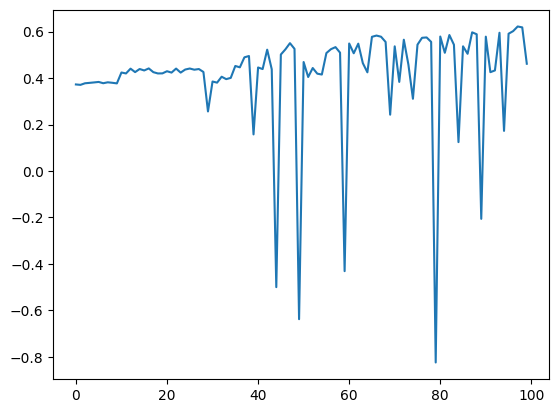

In [ ]:
pd.Series(boosted_nn.estimator.validation_scores_).plot()

In [ ]:
boosted_nn.score(X_valid, y_valid)

0.5820105055173783

/tmp/ipykernel_128503/2726626927.py:36: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


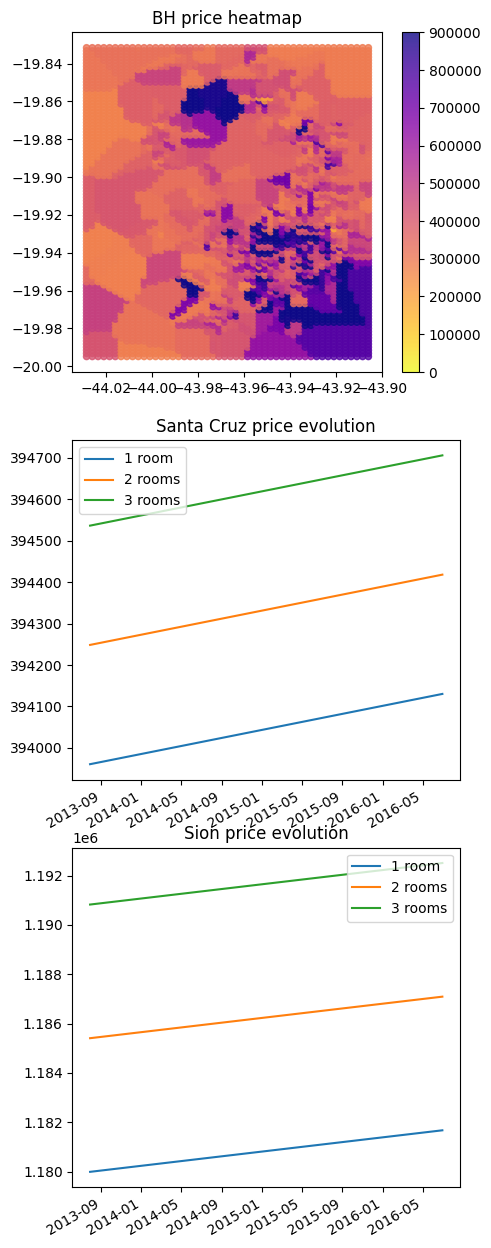

In [ ]:
sanity_checks(boosted_nn, set_color_bounds=True)

## Conclusion

|Model                     |Time to train|Score|BH check                        |Santa Cruz and Sion check                  |
|--------------------------|-------------|-----|--------------------------------|---------------------------------|
|Random Forest             |35.1s        |0.713|Vertical and horizontal patterns|Colapsing curves                 |
|KNN                       |0.3s         |0.448|Random smooth surface           |Super high variance              |
|Neural Network            |7m42.4s      |0.446|Random smooth surface           |Correct curve order but same price for different places and almost constant over time|
|Spatial Boosted Random Forest |44.3s        |0.691|Seems natural                   |Colapsing curves                 |
|Spatial Boosted Neural Network|4m57.9s      |0.582|Seems natural                   |Correct order and arguable price evolution and price difference between places|

Random Forest had the best score but with a little bit more investigation we see a bad geospatial generalization and no price difference when adding more rooms. It seems to overfit but due to a lack of data and not to a model inability. We need more spatial features like distance to the nearest city center, hospital, school, public transportation, etc.

KNN had the best time to train but struggles with all other evaluation criteria.

Neural Network seems to underfit. It's expected given the time to train and the complexity of understanding price fluctuation given only coordinates. It's possible to fit a neural network with this data but only with a lot more time to train.

Instead of adding spatial features like distance to the nearest city center, I decided to use KNN to increase model spatial awareness by adding neighbors as features. In addition, I implemented neighbor randomness to improve model generalization.

Spatial Boosted Random Forest had better geospatial generalization but again seems to overfit due to lack of data.

As neural networks have greater generalization capacity, in the end Spatial Boosted Neural Network was the model that best managed to learn the patterns even with little data. It had the best qualitative performance even scoring worse than other models.

## Improvements

- Generate a GIF to show price evolution throw time.
- Compare computational efficiency.
- Try other dataset to figure out which kind of problem suites better with the technique.
- Identify the way this method affect the base model (needs more tuning?).
- Add a online demo for portifolio purposes.